In [1]:
import numpy as np
from fFunc import Ffunc
from gFunc import Gfunc
from scipy.optimize import curve_fit
from modelVelocity import ModelVelocity
import emcee
import matplotlib.pyplot as plt
import corner

from multiprocessing import get_context
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
def gauss(x, *p):
    A, sigma = p
    return A*np.exp(-x**2/(2.*sigma**2))

In [3]:
def log_prob(x, g_func, f_funcs, r_ins, r_outs, sigma_Bs, sigma_obs, sigma_obs_err, x_min, x_max):

    x_use = np.array(x)

    if len(x_use[x_use<x_min])>0 or len(x_use[x_use>x_max])>0:
       return -np.inf

    n, log_Mbulge, re_bulge, log_Mbh = x_use
    Mbulge = 10**log_Mbulge
    Mbh = 10**log_Mbh

    sigma_model = np.zeros(len(r_ins))
    for k in range(len(r_ins)):
        modelv = ModelVelocity(n, Mbulge, re_bulge, Mbh, sigma_Bs[k], r_ins[k], r_outs[k], g_func, f_func=f_funcs[k])

        vs = np.arange(0, 2000, 100)
        Ivs = np.zeros(vs.shape)
        for i, v in enumerate(vs):
            #Ivs[i] = modelv.Iv(v)
            Ivs[i] = modelv.Iv_romb(v)
        p0 = [0.1, modelv.sigma(0.5*(r_ins[k]+r_outs[k]))]
        coeffs, _ = curve_fit(gauss, vs, Ivs, p0=p0, check_finite=False)
        sigma_model[k] = coeffs[1]
    
    chi2 = np.sum(((sigma_obs-sigma_model)/(sigma_obs_err))**2)
    return -chi2/2.

In [4]:
#These are the ring parameters.
sigma_Bs = [0.2908075, 0.2908075   , 0.424775  , 0.424775  , 0.424775  , 0.424775 ]
r_ins =    [0.       , 0.2908075   , 0.61265625, 0.816875  , 1.02109375, 1.2253125]
r_outs =   [0.2908075, 0.4846791884, 0.816875  , 1.02109375, 1.2253125 , 1.429531250]

In [5]:
#Initialize the g and f functions. 
f_funcs = [None]*len(r_outs)
for i in range(len(r_ins)):
    f_funcs[i] = Ffunc(sigma_Bs[i], r_ins[i], r_outs[i])
g_func = Gfunc()

In [6]:
#Initial guesses. Order is n, 
nwalkers = 32
ndim = 4
#p0 = np.array([4., 10.33, 0.65, 9.6])
#p0 = np.array([4.0, 10., 0.5, 9.])
#p0 = np.array([5.0, 9.5, 0.5, 9.5])
p0 = np.array([1.0, 9.75, 1.5, 9.5])
p0 = p0 * (1+1e-5*np.random.randn(nwalkers, ndim))
#p0 = p0 * (1+1e-2*np.random.randn(nwalkers, ndim))

#p_min = np.array([0.5,  8., 0.1, 0.])
#p_max = np.array([10., 12., 5.0, 11.])
p_min = np.array([0.99,  8., 0.1, 0.])
p_max = np.array([1.01, 12., 5.0, 11.])
#p_min = np.array([3.9,  8., 0.1, 0.])
#p_max = np.array([4.1, 12., 5.0, 11.])
# p_min = np.array([0.99,  0., 1.49, 0.])
# p_max = np.array([1.01, 12., 1.51, 11.])

In [7]:
#Simulate the measurements. 
n, Mbulge, re_bulge, Mbh = (1.0, 10**9.75, 1.5, 10**9.5)
sigma_sim = np.zeros(len(r_ins))
for k in range(len(r_ins)):
    modelv = ModelVelocity(n, Mbulge, re_bulge, Mbh, sigma_Bs[k], r_ins[k], r_outs[k], g_func, f_func=f_funcs[k])

    vs = np.arange(0, 2000, 100)
    Ivs = np.zeros(vs.shape)
    for i, v in enumerate(vs):
        #Ivs[i] = modelv.Iv(v)
        Ivs[i] = modelv.Iv_romb(v)
    c0 = [0.1, modelv.sigma(0.5*(r_ins[k]+r_outs[k]))]
    coeffs, _ = curve_fit(gauss, vs, Ivs, p0=c0, check_finite=False)
    sigma_sim[k] = coeffs[1]
    
sigma_obs_err = 0.01*sigma_sim
sigma_obs = np.random.normal(sigma_sim, sigma_obs_err)

print(sigma_sim, sigma_obs, sigma_obs_err)

[167.8565592  151.22415128 130.47884446 123.81511558 118.28005392
 113.69095278] [170.65304605 154.02833148 129.63465805 123.3430025  116.84838261
 111.39772866] [1.67856559 1.51224151 1.30478844 1.23815116 1.18280054 1.13690953]


In [8]:
log_prob([1.0, 9.7, 1.5, 9.5],g_func, f_funcs, r_ins, r_outs, sigma_Bs, sigma_obs, sigma_obs_err, p_min, p_max)

-8.38840276042614

In [9]:
# nburn = 500
# nsamp = 2000
#nburn = 200
#nsamp = 500
nburn = 1000
nsamp = 10000
with get_context("fork").Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[g_func, f_funcs, r_ins, r_outs, sigma_Bs, sigma_obs, sigma_obs_err, p_min, p_max],pool=pool)
    #sampler.run_mcmc(p0, 500, progress=True)

    state = sampler.run_mcmc(p0, nburn, progress=True)
    sampler.reset()
    sampler.run_mcmc(state, nsamp, progress=True)

100%|██████████| 10000/10000 [13:45<00:00, 12.11it/s]


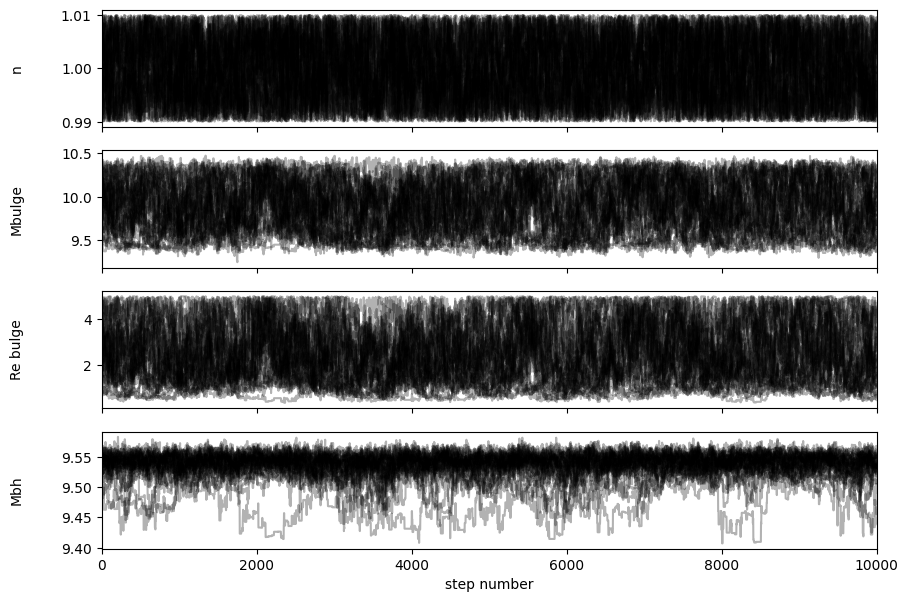

In [10]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["n", "Mbulge", "Re bulge", "Mbh"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
# tau = sampler.get_autocorr_time()
# print(tau)

In [12]:
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
print(flat_samples.shape)

(21312, 4)


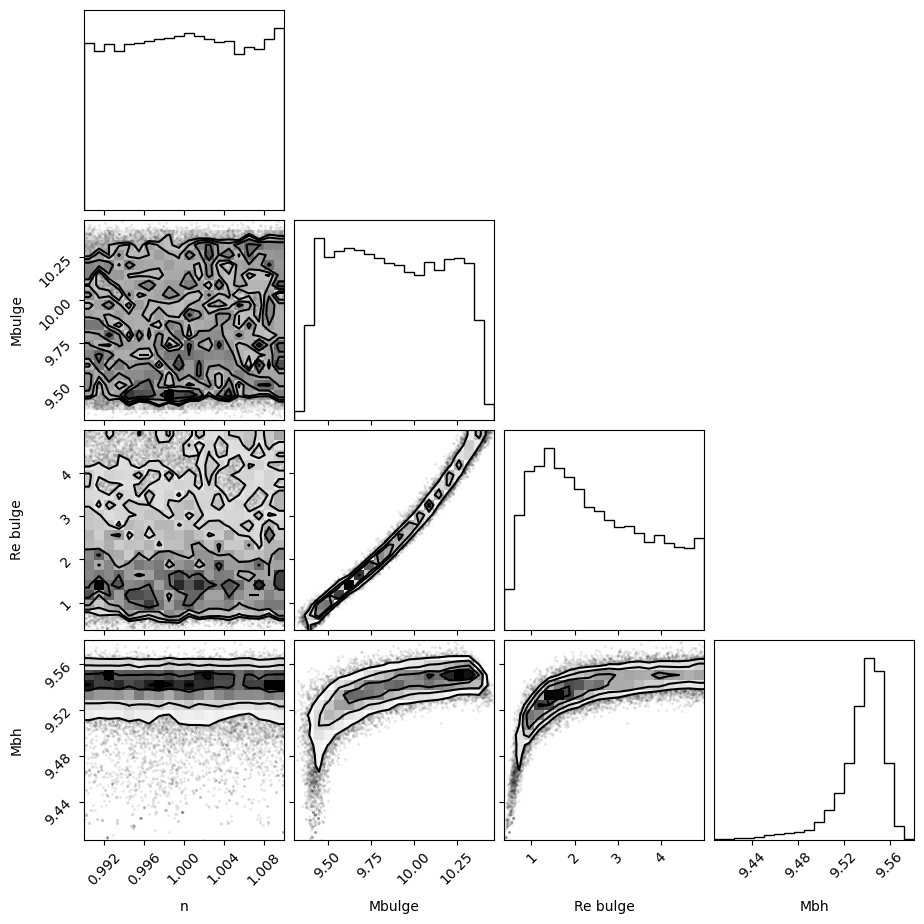

In [13]:
fig = corner.corner(
    flat_samples, labels=labels
);

In [14]:
best_fit = np.median(flat_samples, axis=0)
print(best_fit)
log_prob(best_fit,g_func, f_funcs, r_ins, r_outs, sigma_Bs, sigma_obs, sigma_obs_err, p_min, p_max)

[1.00005286 9.86805991 2.27977303 9.54010728]


-0.6762441294168083

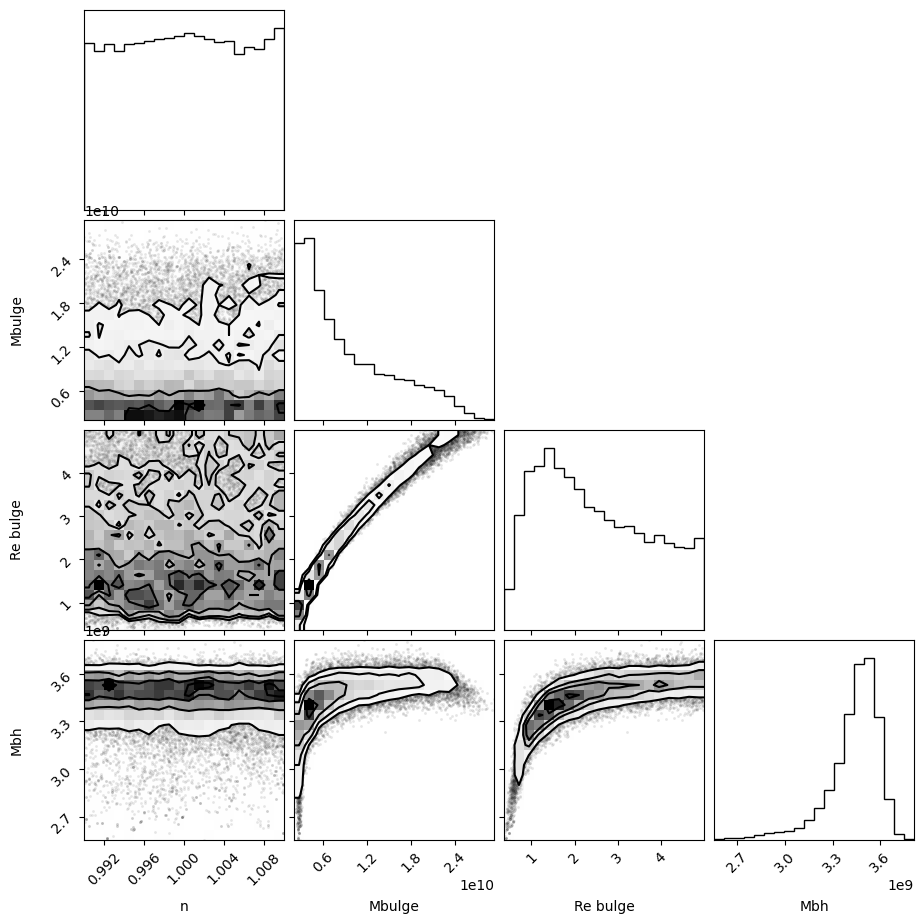

In [15]:
flat_samples2 = np.copy(flat_samples)
flat_samples2[:,1] = 10**flat_samples2[:,1]
flat_samples2[:,3] = 10**flat_samples2[:,3]
fig = corner.corner(
    flat_samples2, labels=labels
);